In [1]:
import gensim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_addons as tfa

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Flatten, Dense, TimeDistributed, \
    SpatialDropout1D, Bidirectional, Conv1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D, \
    Concatenate, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report

%matplotlib inline

In [2]:
class ConfusionMatrixMetric(tf.keras.metrics.Metric):
    def __init__(self, num_classes, **kwargs):
        super(ConfusionMatrixMetric,self).__init__(name='confusion_matrix_metric',**kwargs)
        self.num_classes=num_classes
        self.total_cm = self.add_weight("total", shape=(num_classes,num_classes), initializer="zeros")
        
    def reset_states(self):
        for s in self.variables:
            s.assign(tf.zeros(shape=s.shape))
            
    def update_state(self, y_true, y_pred,sample_weight=None):
        self.total_cm.assign_add(self.confusion_matrix(y_true,y_pred))
        return self.total_cm
        
    def result(self):
        return self.process_confusion_matrix()
    
    def confusion_matrix(self,y_true, y_pred):
        y_pred = tf.argmax(y_pred, axis=2)
        y_true = tf.argmax(y_true, axis=2)

        y_pred = tf.reshape(y_pred, [-1])
        y_true = tf.reshape(y_true, [-1])
  
        cm = tf.math.confusion_matrix(
            y_true, 
            y_pred, 
            dtype=tf.float32, 
            num_classes=self.num_classes
        )
        
        return cm
    
    def process_confusion_matrix(self):
        cm = self.total_cm
        diag_part=tf.linalg.diag_part(cm)
        precision=diag_part/(tf.reduce_sum(cm,0)+tf.constant(1e-15))
        recall=diag_part/(tf.reduce_sum(cm,1)+tf.constant(1e-15))
        f1=2*precision*recall/(precision+recall+tf.constant(1e-15))
        return precision, recall, f1
    
    def fill_output(self,output):
        results=self.result()
        for i in range(self.num_classes):
            output['precision_{}'.format(i)]=results[0][i]
            output['recall_{}'.format(i)]=results[1][i]
            output['f1_{}'.format(i)]=results[2][i]

In [3]:
df = pd.read_csv('../data/data.csv')

In [4]:
df.head()

,word,tag
0,Pengamat,O
1,politik,O
2,dari,O
3,Universitas,B-ORGANIZATION
4,Gadjah,I-ORGANIZATION


In [5]:
sentences = []
cnt = 1

for i in df.itertuples():
    sentences.append(cnt)
    
    if '.' in str(i.word):
        cnt += 1
        
df['sentence #'] = sentences
df.head()

,word,tag,sentence #
0,Pengamat,O,1
1,politik,O,1
2,dari,O,1
3,Universitas,B-ORGANIZATION,1
4,Gadjah,I-ORGANIZATION,1


In [6]:
agg_func = lambda s: [(w, t) for w, t in zip(s['word'].values.tolist(), s['tag'].values.tolist())]
grouped = df.groupby('sentence #').apply(agg_func)
sentences = [s for s in grouped]

In [7]:
words = list(set(df['word'].values))
words.append('PADDING')
num_words = len(words)
tags = list(set(df['tag'].values))
num_tags = len(tags)

In [8]:
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate([tag for tag in tags if tag != 'O'])}
tag2idx['O'] = len(tags)-1

In [9]:
tag2idx

{'B-LOCATION': 0,
 'B-ORGANIZATION': 1,
 'I-PERSON': 2,
 'B-PERSON': 3,
 'U-PERSON': 4,
 'U-LOCATION': 5,
 'B-TIME': 6,
 'U-ORGANIZATION': 7,
 'L-PERSON': 8,
 'L-QUANTITY': 9,
 'U-QUANTITY': 10,
 'I-LOCATION': 11,
 'I-ORGANIZATION': 12,
 'U-TIME': 13,
 'I-QUANTITY': 14,
 'L-ORGANIZATION': 15,
 'B-QUANTITY': 16,
 'L-LOCATION': 17,
 'L-TIME': 18,
 'I-TIME': 19,
 'O': 20}

In [10]:
max_len = 60
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding='post', value=num_words-1)

y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding='post', value=tag2idx['O'])
y = [to_categorical(i, num_classes=num_tags) for i in y]

In [11]:
x_train, x_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=1)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=1)

In [12]:
# model = gensim.models.Word2Vec.load("../checkpoint/w2vec_wiki_id_case")

In [13]:
# embedding_matrix = np.zeros((len(words), 400))

# for i, w in enumerate(words):
#     try:
#         embedding_vector = model.wv[w]
#         embedding_matrix[i] = embedding_vector
#     except:
#         embedding_matrix[i] = np.random.normal(0, np.sqrt(0.25), 400)

In [14]:
# embedding_matrix.shape

In [15]:
input_sequence = Input(shape=(max_len, ))
model = Embedding(
        input_dim=num_words,
        output_dim=400,
        input_length=max_len,
)(input_sequence)
model = SpatialDropout1D(0.5)(model)
model2g = Conv1D(128, 2, activation='relu', padding='same')(model)
model4g = Conv1D(128, 4, activation='relu', padding='same')(model)
model6g = Conv1D(128, 6, activation='relu', padding='same')(model)
model8g = Conv1D(128, 8, activation='relu', padding='same')(model)
model10g = Conv1D(128, 10, activation='relu', padding='same')(model)
model = concatenate([model2g, model4g, model6g, model8g, model10g])
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.5))(model)
output_sequence = Dense(num_tags, activation='softmax')(model)
model = Model(input_sequence, output_sequence)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 400)      5212400     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d (SpatialDropo (None, 60, 400)      0           embedding[0][0]                  
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 60, 128)      102528      spatial_dropout1d[0][0]          
______________________________________________________________________________________________

In [16]:
f1_score = tfa.metrics.F1Score(
    num_classes=num_tags,
    average='micro',
    name='f1_score',
    threshold=0.5
)

loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(lr=0.001)

model.compile(loss=loss, optimizer=optimizer, metrics=[f1_score])

In [17]:
early_stopping = EarlyStopping(patience=10)

history = model.fit(
    x_train, np.array(y_train),
    validation_data=(x_val, np.array(y_val)),
    batch_size=64,
    epochs=100,
    verbose=1,
    callbacks=[early_stopping]
)

Train on 3424 samples, validate on 734 samples
Epoch 1/100
3424/3424 [==============================] - 38s 11ms/sample - loss: 0.4597 - f1_score: 0.9093 - val_loss: 0.2736 - val_f1_score: 0.9451
Epoch 2/100
3424/3424 [==============================] - 47s 14ms/sample - loss: 0.2455 - f1_score: 0.9494 - val_loss: 0.2138 - val_f1_score: 0.9559
Epoch 3/100
3424/3424 [==============================] - 58s 17ms/sample - loss: 0.1699 - f1_score: 0.9625 - val_loss: 0.1667 - val_f1_score: 0.9613
Epoch 4/100
3424/3424 [==============================] - 59s 17ms/sample - loss: 0.1131 - f1_score: 0.9685 - val_loss: 0.1392 - val_f1_score: 0.9668
Epoch 5/100
3424/3424 [==============================] - 61s 18ms/sample - loss: 0.0729 - f1_score: 0.9791 - val_loss: 0.1217 - val_f1_score: 0.9715
Epoch 6/100
3424/3424 [==============================] - 64s 19ms/sample - loss: 0.0438 - f1_score: 0.9881 - val_loss: 0.1156 - val_f1_score: 0.9729
Epoch 7/100
3424/3424 [==============================] - 63

(0.0, 1.0)

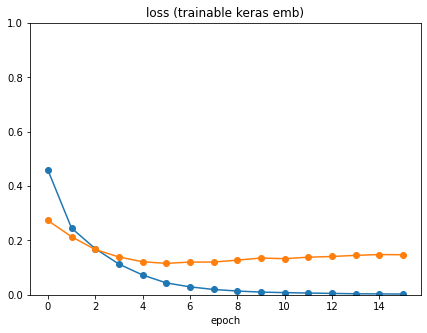

In [33]:
fig=plt.figure(figsize=(7,5))
plt.plot(history.history['loss'], "-o")
plt.plot(history.history['val_loss'], "-o")
plt.title('loss (trainable keras emb)')
plt.xlabel('epoch')
plt.ylim(0, 1)

(0.0, 1.0)

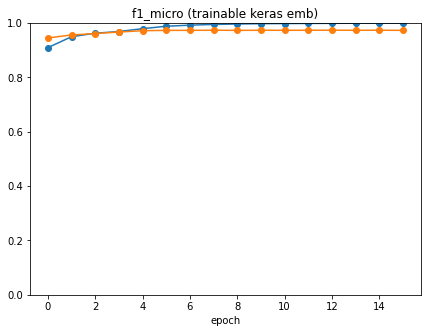

In [34]:
fig=plt.figure(figsize=(7,5))
plt.plot(history.history['f1_score'], "-o")
plt.plot(history.history['val_f1_score'], "-o")
plt.title('f1_micro (trainable keras emb)')
plt.xlabel('epoch')
plt.ylim(0,1)

In [20]:
tags = [t for t in tag2idx]

In [21]:
y_pred=model(x_test)
y_pred_tags=np.argmax(y_pred, -1)

In [22]:
cm=ConfusionMatrixMetric(num_tags)
_=cm.update_state(y_test,y_pred)

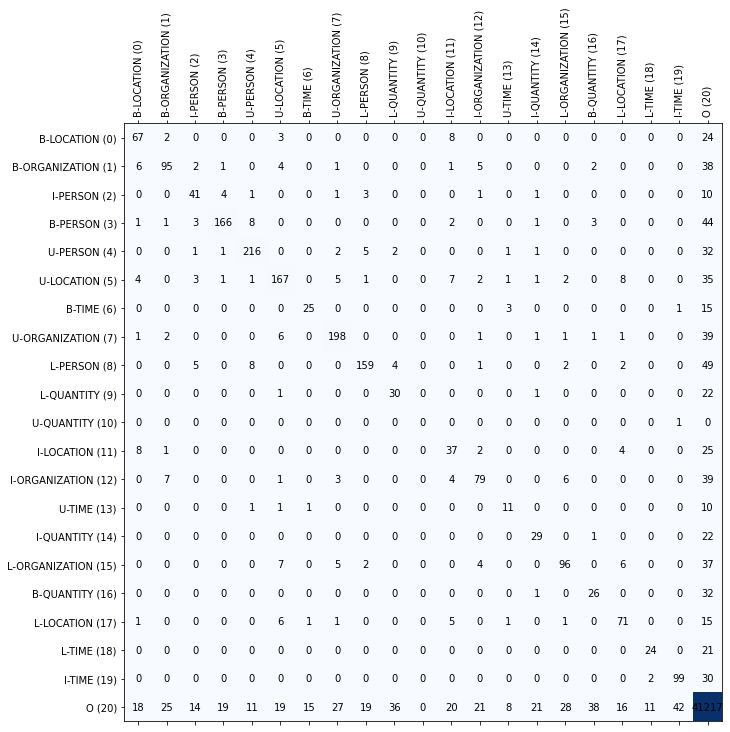

In [23]:
fig, ax = plt.subplots(figsize=(11,11))

cm_matrix = cm.total_cm.numpy().astype(np.int32)

ax.matshow(cm_matrix, cmap=plt.cm.Blues)

for i in range(num_tags):
    for j in range(num_tags):
        c = cm_matrix[j,i]
        ax.text(i, j, str(c), va='center', ha='center')

plt.xticks(range(num_tags),['{} ({})'.format(tags[i],i) for i in range(num_tags)])
plt.yticks(range(num_tags),['{} ({})'.format(tags[i],i) for i in range(num_tags)])
plt.xticks(rotation=90)
plt.show()

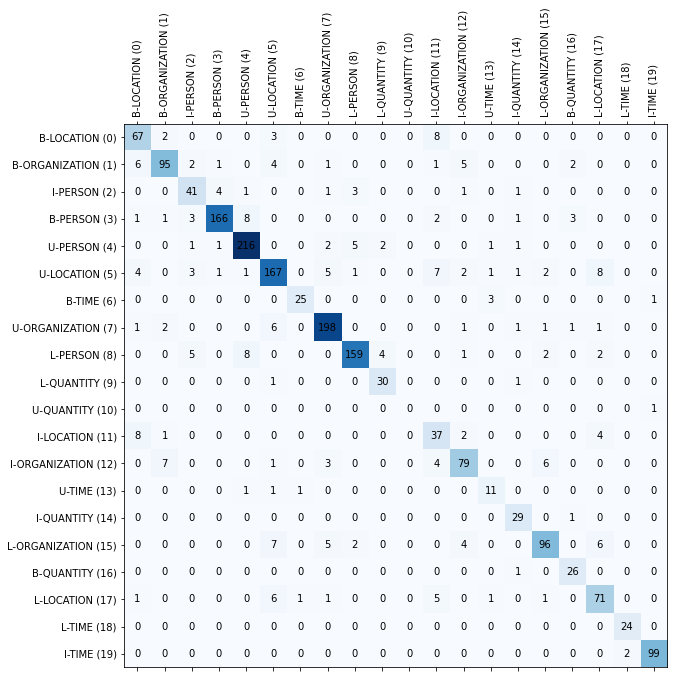

In [24]:
new_tags = tags[:-1]

fig, ax = plt.subplots(figsize=(10,10))

cm_matrix = cm.total_cm.numpy().astype(np.int32)
cm_matrix = np.delete(cm_matrix, (20), axis=0)
cm_matrix = np.delete(cm_matrix, (20), axis=1)

ax.matshow(cm_matrix, cmap=plt.cm.Blues)

for i in range(num_tags-1):
    for j in range(num_tags-1):
        c = cm_matrix[j,i]
        ax.text(i, j, str(c), va='center', ha='center')
        
plt.xticks(range(num_tags-1),['{} ({})'.format(new_tags[i],i) for i in range(num_tags-1)])
plt.yticks(range(num_tags-1),['{} ({})'.format(new_tags[i],i) for i in range(num_tags-1)])
plt.xticks(rotation=90)
plt.show()

In [25]:
from sklearn.metrics import f1_score

In [26]:
preds = []
actuals = []

for i, xt in enumerate(x_test):
    p = model.predict(np.array([xt]))
    p = np.argmax(p, axis=-1)
    y_true = np.argmax(np.array(y_test), axis=-1)[i]
    
    for true, pred in zip(y_true, p[0]):
        actuals.append(true)
        preds.append(pred)
        
print(f1_score(preds, actuals, average='micro'))
print(precision_score(preds, actuals, average='micro'))
print(recall_score(preds, actuals, average='micro'))

0.973047229791099
0.973047229791099
0.973047229791099


In [27]:
print(classification_report(actuals, preds, target_names=tags, ))

                precision    recall  f1-score   support

    B-LOCATION       0.63      0.64      0.64       104
B-ORGANIZATION       0.71      0.61      0.66       155
      I-PERSON       0.59      0.66      0.63        62
      B-PERSON       0.86      0.72      0.79       229
      U-PERSON       0.88      0.83      0.85       261
    U-LOCATION       0.78      0.70      0.74       238
        B-TIME       0.60      0.57      0.58        44
U-ORGANIZATION       0.81      0.79      0.80       251
      L-PERSON       0.84      0.69      0.76       230
    L-QUANTITY       0.42      0.56      0.48        54
    U-QUANTITY       0.00      0.00      0.00         1
    I-LOCATION       0.44      0.48      0.46        77
I-ORGANIZATION       0.68      0.57      0.62       139
        U-TIME       0.44      0.46      0.45        24
    I-QUANTITY       0.51      0.56      0.53        52
L-ORGANIZATION       0.71      0.61      0.66       157
    B-QUANTITY       0.37      0.44      0.40  

/Users/sahrul/miniconda3/envs/ner/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
preds = []
actuals = []

for i, xt in enumerate(x_test):
    p = model.predict(np.array([xt]))
    p = np.argmax(p, axis=-1)
    y_true = np.argmax(np.array(y_test), axis=-1)[i]
    
    if 13030 in list(xt):
        first_pad_idx = list(xt).index(13030)
        _zip = zip(y_true[:first_pad_idx], p[0][:first_pad_idx])
    else:
        _zip = zip(y_true, p[0])
    
    for true, pred in _zip:
        actuals.append(true)
        preds.append(pred)

print(f1_score(preds, actuals, average='micro'))
print(precision_score(preds, actuals, average='micro'))
print(recall_score(preds, actuals, average='micro'))

0.9178489860890027
0.9178489860890027
0.9178489860890027


In [29]:
print(classification_report(actuals, preds, target_names=tags))

                precision    recall  f1-score   support

    B-LOCATION       0.63      0.64      0.64       104
B-ORGANIZATION       0.71      0.61      0.66       155
      I-PERSON       0.59      0.66      0.63        62
      B-PERSON       0.86      0.72      0.79       229
      U-PERSON       0.88      0.83      0.85       261
    U-LOCATION       0.78      0.70      0.74       238
        B-TIME       0.60      0.57      0.58        44
U-ORGANIZATION       0.81      0.79      0.80       251
      L-PERSON       0.84      0.69      0.76       230
    L-QUANTITY       0.42      0.56      0.48        54
    U-QUANTITY       0.00      0.00      0.00         1
    I-LOCATION       0.44      0.48      0.46        77
I-ORGANIZATION       0.68      0.57      0.62       139
        U-TIME       0.44      0.46      0.45        24
    I-QUANTITY       0.51      0.56      0.53        52
L-ORGANIZATION       0.71      0.61      0.66       157
    B-QUANTITY       0.37      0.44      0.40  

In [30]:
i = np.random.randint(0, x_test.shape[0])
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)

y_true = np.argmax(np.array(y_test), axis=-1)[i]

print('{:15}{:15}\t {}\n'.format('word', 'actual', 'pred'))
print('-'*40)

for w, true, pred in zip(x_test[i], y_true, p[0]):
    print('{:15}{:15}\t {}'.format(words[w], tags[true], tags[pred]))

word           actual         	 pred

----------------------------------------
Sidang         O              	 O
pun            O              	 O
akhirnya       O              	 O
tetap          O              	 O
dilanjutkan    O              	 O
.              O              	 O
PADDING        O              	 O
PADDING        O              	 O
PADDING        O              	 O
PADDING        O              	 O
PADDING        O              	 O
PADDING        O              	 O
PADDING        O              	 O
PADDING        O              	 O
PADDING        O              	 O
PADDING        O              	 O
PADDING        O              	 O
PADDING        O              	 O
PADDING        O              	 O
PADDING        O              	 O
PADDING        O              	 O
PADDING        O              	 O
PADDING        O              	 O
PADDING        O              	 O
PADDING        O              	 O
PADDING        O              	 O
PADDING        O              	 O
PAD